In [2]:
import pandas as pd
from pandas import DataFrame as df
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# data preprocessing:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE 
from sklearn.preprocessing import StandardScaler
# models:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# evaluation:
from Utils import evaluation_metrics, cv_scores, evaluation_scores

# 0. Loading the data

In [3]:
data = pd.read_csv("haberman.csv")
data.head()

,Age,Year_of_op,Nbr_of_nodes,Surv_status
0,30,64,1,1
1,30,62,3,1
2,30,65,0,1
3,31,59,2,1
4,31,65,4,1


# 1. Preprocessing the data

We preprocess the data same way we did in the project one which consisted the removement of outliers (too high values in Number of node column), balancing the data, normalizing the data, recoding the output variable and dividing the data into training and testing set.

**1.1. Removing the outliers**

In [4]:
a = data[data["Nbr_of_nodes"] > 30]
print("Observations with too high value in Number of node column:\n", a)

Observations with too high value in Number of node column:
      Age  Year_of_op  Nbr_of_nodes  Surv_status
62    43          58            52            2
174   54          67            46            1
215   59          62            35            2


In [5]:
# removing those three observations:
data = data.drop([62, 174, 215])

**1.2. Recoding the output variable (Survival status)**

In [6]:
data["Surv_status"] = data["Surv_status"].replace([1, 2], [0, 1])

**1.3. Dividing the data into training and testing sets**

In [7]:
x_train, x_test, y_train, y_test = train_test_split(data.drop(columns=["Surv_status"]), data["Surv_status"],
                                                   test_size=0.3, random_state=50, stratify=data["Surv_status"])
print("Train set size:", x_train.shape)
print("Test set size:", x_test.shape)

Train set size: (212, 3)
Test set size: (91, 3)


In [8]:
print("Train output values:\n" + str(y_train.value_counts()))
print("\nTest output values:\n" + str(y_test.value_counts()))

Train output values:
0    157
1     55
Name: Surv_status, dtype: int64

Test output values:
0    67
1    24
Name: Surv_status, dtype: int64


**1.4. Balancing the data (using SMOTE method)**

In [9]:
sm = SMOTE(random_state=5)
x_train, y_train = sm.fit_resample(x_train, y_train)
x_test, y_test = sm.fit_resample(x_test, y_test)
print("Train set output size:\n" + str(y_train.value_counts()))
print("\nTest set output size:\n" + str(y_test.value_counts()))

Train set output size:
0    157
1    157
Name: Surv_status, dtype: int64

Test set output size:
0    67
1    67
Name: Surv_status, dtype: int64


**1.5. Normalizing the data**

In [10]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

# 2. The logistic regression model from the project one (baseline)

In the project one we implemented four machine learning models which were; logistic regression, logistic ridge regression, logistic lasso regression and logistic elastic net regression. After evaluating and comparing the models we saw that the logistic regression model without the regularization was the best one for our data. Becuase of that we will now implement the logistic regression model same way we did it in the project one to set it as an baseline for this project's models. In the end of this project it is interesting to compare all the models including logistic regression model to saw which one is the best for our data.

We will build the logistic regression model by only using number of nodes variable as an explanatory variable beacause we saw that with the other two explanatory variables the model got worse evaluation metrics than the model with only number of nodes explanatory variable.

*** LOGISTIC REGRESSION EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.58      0.79      0.67       157
 surv. status < 5 years       0.67      0.42      0.52       157

               accuracy                           0.61       314
              macro avg       0.62      0.61      0.59       314
           weighted avg       0.62      0.61      0.59       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.61      0.81      0.70        67
 surv. status < 5 years       0.72      0.49      0.58        67

               accuracy                           0.65       134
              macro avg       0.67      0.65      0.64       134
           weighted avg       0.67      0.65      0.64       134



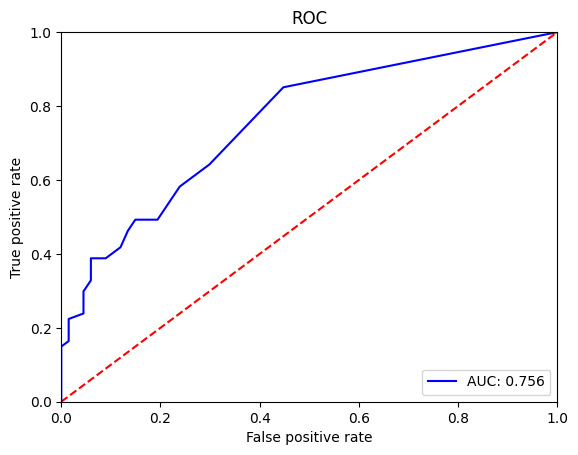

In [12]:
# training:
x_train_mod = x_train[:,2].reshape([len(x_train), 1])
regressor = LogisticRegression()
regressor_trnd = regressor.fit(x_train_mod, y_train)
x_test_mod = x_test[:,2].reshape([len(x_test), 1]) # modifying the x test set
# evaluating:
print("*** LOGISTIC REGRESSION EVALUATION: ***")
c_report_logreg, auc_logreg = evaluation_metrics(regressor_trnd, x_train_mod, x_test_mod, y_train, y_test)

In [ ]:
# for the final comparison (section 4):
acc_lr, pre_lr, sen_lr = evaluation_scores(regressor_trnd, x_test_mod, y_test)

# 3. Models

After implementing and analyzing the parametric models (project one), in this project we will implement three non-parametric models and analyze their performance. We are going to implement three supervised learning models which are K-Nearest Neighbours, Gradient Boosting Trees and Artificial neural network.

After implementing the models we will analyze and compare their performance and pick the best one.

# 3.1. K-NN

We start with K-nearest neighbors classifier which is supervised learning model. The way how the model works is that it classifies the new observation based on the k nearest data points. For example if the k is five and three of the closest data points belongs to class one, the model classifies the new data point belonging to class one. So when we start to implement the model we have to find the optimal value of k. For that we use cross-validation and to score the models with a different k values we use accuracy because it takes into account the both true positive and negative classifications. After finding the optimal k-value we calculate some model evaluation merits.

The optimal k: {'n_neighbors': 1}
The best accuracy score: 0.7391193036354327


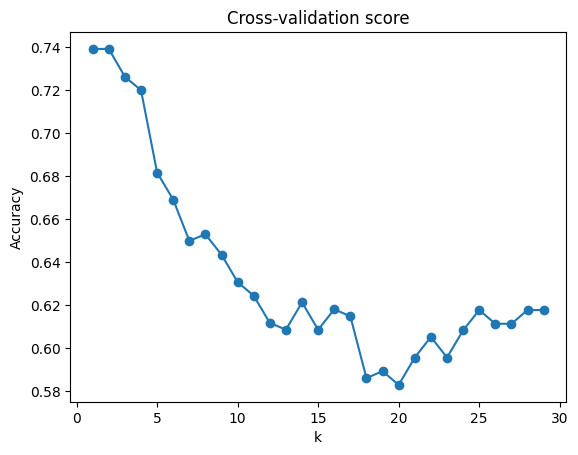

In [11]:
# finding the optimal k
param_grid = {"n_neighbors": range(1, 30)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", cv=5)
grid.fit(x_train, y_train)
print("The optimal k:", grid.best_params_)
print("The best accuracy score:", grid.best_score_)

# plotting the scores
scores = np.array(grid.cv_results_["mean_test_score"])
n_of_k = np.array(param_grid["n_neighbors"])
plt.figure()
plt.plot(n_of_k, scores, "o-")
plt.xlabel("k"); plt.ylabel("Accuracy")
plt.title("Cross-validation score")
plt.show()

From figure we can see that models with the k one and two got equal and the best accuracy score. Next we try to do cross-validation with three folds to hopefully make our decision easier. 

The optimal k: {'n_neighbors': 2}
The best accuracy score: 0.7452380952380953


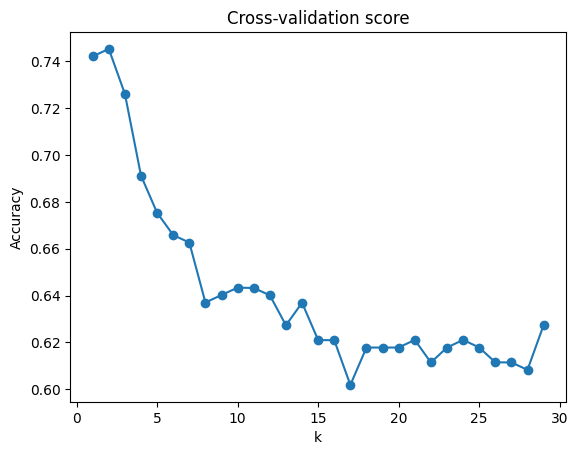

In [12]:
param_grid = {"n_neighbors": range(1, 30)}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, scoring="accuracy", cv=3)
grid.fit(x_train, y_train)
print("The optimal k:", grid.best_params_)
print("The best accuracy score:", grid.best_score_)

# plotting the scores
scores = np.array(grid.cv_results_["mean_test_score"])
n_of_k = np.array(param_grid["n_neighbors"])
plt.figure()
plt.plot(n_of_k, scores, "o-")
plt.xlabel("k"); plt.ylabel("Accuracy")
plt.title("Cross-validation score")
plt.show()

With three folds we got little bit different result. Because k=2 got the best score in both cross-validtions we pick it to our model.

*** K-NN EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.82      1.00      0.90       157
 surv. status < 5 years       1.00      0.78      0.87       157

               accuracy                           0.89       314
              macro avg       0.91      0.89      0.89       314
           weighted avg       0.91      0.89      0.89       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.53      0.88      0.66        67
 surv. status < 5 years       0.65      0.22      0.33        67

               accuracy                           0.55       134
              macro avg       0.59      0.55      0.50       134
           weighted avg       0.59      0.55      0.50       134



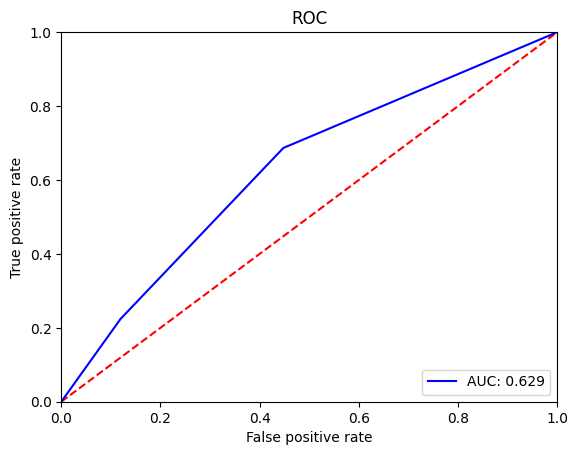

In [14]:
# implementig the model with k=2
knn_model = KNeighborsClassifier(n_neighbors=2).fit(x_train, y_train)

# evaluation metrics
print("*** K-NN EVALUATION: ***")
c_report_knn, auc_knn = evaluation_metrics(knn_model, x_train, x_test, y_train, y_test)

From the train set report we can see that the model overfits to the training data heavily and that's why the test set metrics are so bad (accuracy=0.55 for example). To prevent the K-NN model to overfit to the training data we have to increase the number of neighbors. From the first cross-validation score figure we can see that between k=4 and k=5 there is a bigger drop in the accuracy score. So maybe with k=4 we can prevent the model to overfit to the training data but still got good accuracy? Let's try that.

*** K-NN EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.81      0.89      0.85       157
 surv. status < 5 years       0.87      0.80      0.83       157

               accuracy                           0.84       314
              macro avg       0.84      0.84      0.84       314
           weighted avg       0.84      0.84      0.84       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.59      0.82      0.68        67
 surv. status < 5 years       0.70      0.42      0.52        67

               accuracy                           0.62       134
              macro avg       0.64      0.62      0.60       134
           weighted avg       0.64      0.62      0.60       134



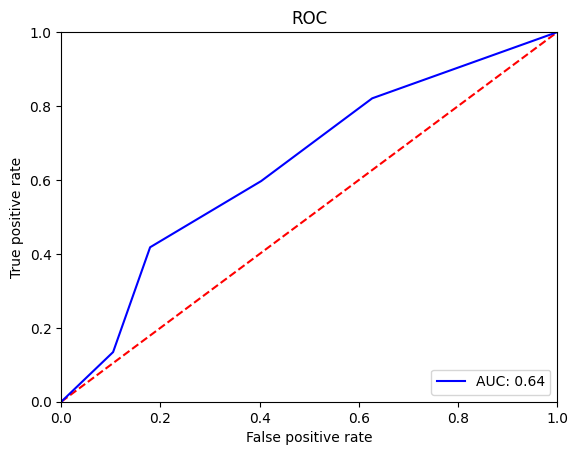

In [18]:
# building the model with k=4:
knn_model = KNeighborsClassifier(n_neighbors=4).fit(x_train, y_train)

# evaluation metrics
print("*** K-NN EVALUATION: ***")
c_report_knn, auc_knn = evaluation_metrics(knn_model, x_train, x_test, y_train, y_test)
# for the final comparison (section 4):
acc_lr, pre_lr, sen_lr = evaluation_scores(regressor_trnd, x_test_mod, y_test)

Now when we compare the two different models with different k we can see that when increasing the number of neighbors from two to four we were able to prevent the model from overfitting to the training data and to improve the model's prediction performance. Next we analyze the k=4 model's evaluation metrics.

**THE K-NN MODEL EVALUATION (k=4):**
- **The accuracy = 0.62:** Shows that the model classified 62% of the test set patients correctly.
- **The precision:** Shows that the model classified correctly 59% of the test set's patients which it classified to belong to the class survival status five or more years and 70% of the patients which it classified to belong to the survival status less than five years class.
- **The recall:** Shows that the model classified the patients who belong to the class survival status five or more years 82% correctly and 42% correctly the patients who belong to the class survival status less than five years.
- **F1-score:** Because the f1-score is the average of the precision and recall it allows us to compare which class the model classified better. Because the class with the survival status five or more years has higher score than less than five years class the model classified it better.

**COMPARING THE MODEL TO THE BASELINE MODEL:**

In [28]:
print("**LOGISTIC REGRESSION (BASELINE)**\n", c_report_logreg, "\nAUC:", round(auc_logreg,2))
print("\n---------", "\n**K-NN**\n", c_report_knn, "\nAUC:", round(auc_knn,2))

**LOGISTIC REGRESSION (BASELINE)**
                          precision    recall  f1-score   support

surv. status >= 5 years       0.61      0.81      0.70        67
 surv. status < 5 years       0.72      0.49      0.58        67

               accuracy                           0.65       134
              macro avg       0.67      0.65      0.64       134
           weighted avg       0.67      0.65      0.64       134
 
AUC: 0.76

--------- 
**K-NN**
                          precision    recall  f1-score   support

surv. status >= 5 years       0.59      0.82      0.68        67
 surv. status < 5 years       0.70      0.42      0.52        67

               accuracy                           0.62       134
              macro avg       0.64      0.62      0.60       134
           weighted avg       0.64      0.62      0.60       134
 
AUC: 0.64


Briefly we can say that the K-NN model didn't perform as well as the baseline model because the baseline model got better metrics. For example accuracy, precision, recall, auc and f1-scores are all better in the baseline model.

In [19]:
# for the final comparison (section 4):
acc_knn, pre_knn, sen_knn = evaluation_scores(knn_model, x_test, y_test)

# 3.2. Gradient Boosting Trees

Next we implement the Gradient boosting trees model which consists many simple decision trees but the difference to the Random forest models is that in Gradient boosting trees every new decision tree in model tries to correct the error the previous ones has done. The way this method practically works is that when the model starts to train new tree to the model the observations previous trees classified wrong has a weight over one so this new tree has bigger probability to classify those obervations right. When all the decision trees have been trained the classification of the new data is a linear combination of the individual decision trees classifications.

When starting to implement the Gradient boosting trees model we have to optimize three parameters which are number of estimators, learning rate and maximum depth. Number of estimators means the amount of decision trees in the model. Learning rate is a parameter which tries to prevent model not to overfit. When setting learning rate small the model "can't learn so well". The maximum depth parameter defines how many variables the decision trees consists. Because the idea in the Gradient boosting trees is that we combine many bad performing trees, we wan't to set the depth of trees pretty small.

In [15]:
# finding the optimal parameters:
model = GradientBoostingClassifier(random_state=5)
param_grid = {"n_estimators" : [50, 100, 200, 500, 1000],
             "learning_rate" : [0.001, 0.005, 0.01, 0.05, 0.1],
             "max_depth" : [1, 2, 3]}
grid = GridSearchCV(model, param_grid, scoring="accuracy", cv=5)
grid.fit(x_train, y_train)
print("Optimal parameters:", grid.best_params_)
print("The best accuracy score:", grid.best_score_)

Optimal parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
The best accuracy score: 0.7390681003584229


*** GRADIENT BOOSTING TREES EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.98      0.97      0.98       157
 surv. status < 5 years       0.97      0.98      0.98       157

               accuracy                           0.98       314
              macro avg       0.98      0.98      0.98       314
           weighted avg       0.98      0.98      0.98       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.56      0.69      0.62        67
 surv. status < 5 years       0.60      0.46      0.52        67

               accuracy                           0.57       134
              macro avg       0.58      0.57      0.57       134
           weighted avg       0.58      0.57      0.57       134



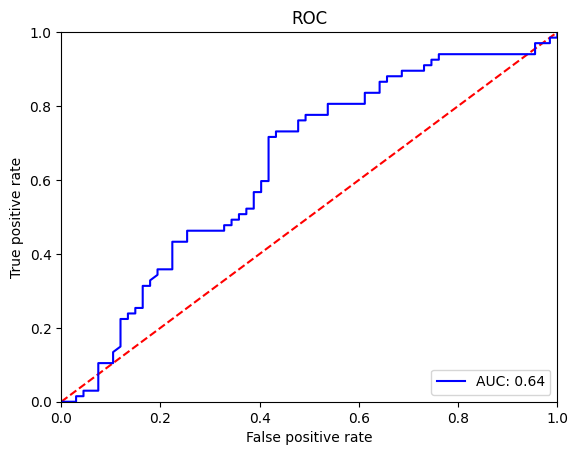

In [11]:
# building the model using the optimal parameters:
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=500, random_state=5).fit(x_train, y_train)

# evaluation metrics
print("*** GRADIENT BOOSTING TREES EVALUATION: ***")
c_report_gbt, auc_gbt = evaluation_metrics(model, x_train, x_test, y_train, y_test)

Similarly than in K-NN model we can see that the gbt model overfitted heavily to the training data with those parameter values. To prevent the model to overfit we can for example decrease the number of estimators in the model. To find the more optimal value for the number of estimators variable we will next examine how the accuracy of the model changes when we change the number of estimators value (using training set). After we have found better value for the parameter we will compute the evaluation metrics again and check if it helped.

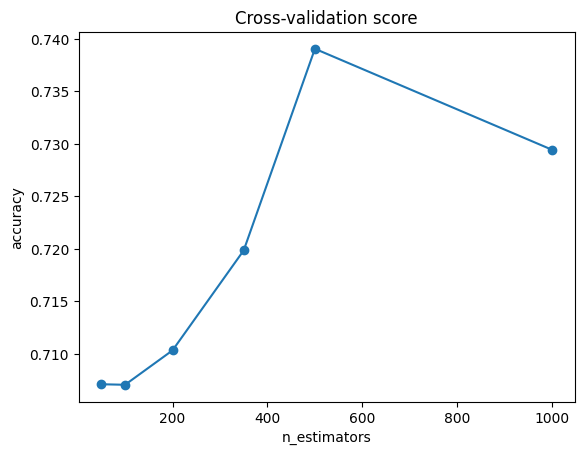

In [12]:
# cross-validation for the number of estimators:
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, random_state=5)
param_grid = {"n_estimators" : [50, 100, 200, 350, 500, 1000]}
cv_scores(model, param_grid, "accuracy", x_train, y_train)

From the figure we can see that if we decrease the number of estimators from 500 to 200 the accuracy score should drop only three units. Because with 200 estimators the model should not overfit at least as heavily as with 500 estimators we will next build the model using 200 estimators and compute some evaluation metrics.

*** GRADIENT BOOSTING TREES EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.97      0.94      0.95       157
 surv. status < 5 years       0.94      0.97      0.96       157

               accuracy                           0.96       314
              macro avg       0.96      0.96      0.96       314
           weighted avg       0.96      0.96      0.96       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.57      0.70      0.63        67
 surv. status < 5 years       0.61      0.46      0.53        67

               accuracy                           0.58       134
              macro avg       0.59      0.58      0.58       134
           weighted avg       0.59      0.58      0.58       134



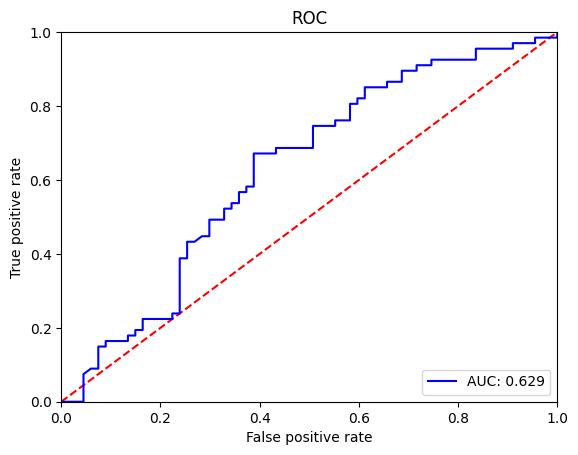

In [13]:
# building the model using n_estimators=200:
model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=200, random_state=5).fit(x_train, y_train)

# evaluation metrics
print("*** GRADIENT BOOSTING TREES EVALUATION: ***")
c_report_gbt, auc_gbt = evaluation_metrics(model, x_train, x_test, y_train, y_test)

Because the model overfits still heavily we will try to decrease the learning rate parameter. We will do exactly the same steps we did when we were finding the smaller value for number of estimators and we will use n_estimators=200.

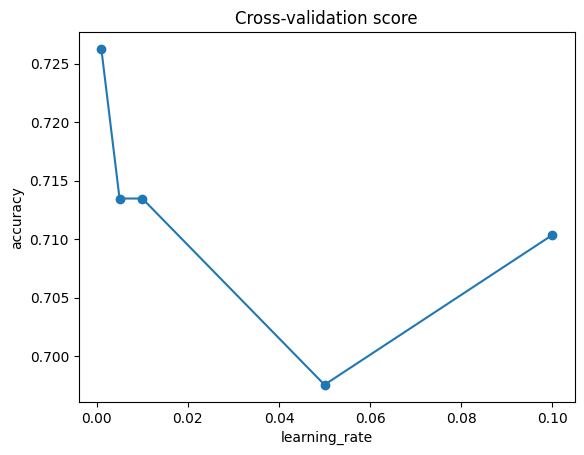

In [14]:
# cross-validation for the learning rate:
model = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=5)
param_grid = {"learning_rate" : [0.001, 0.005, 0.01, 0.05, 0.1]}
cv_scores(model, param_grid, "accuracy", x_train, y_train)

From the figure we can see that actually if we decrease the learning rate from 0.1 to 0.001 we should be able to improve the accuracy of the model even in a training stage. So next we will set the learning rate to 0.001 and build the model again to see if it is still overfitting.

*** GRADIENT BOOSTING TREES EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.79      0.71      0.75       157
 surv. status < 5 years       0.74      0.82      0.77       157

               accuracy                           0.76       314
              macro avg       0.76      0.76      0.76       314
           weighted avg       0.76      0.76      0.76       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.63      0.69      0.66        67
 surv. status < 5 years       0.66      0.60      0.62        67

               accuracy                           0.64       134
              macro avg       0.64      0.64      0.64       134
           weighted avg       0.64      0.64      0.64       134



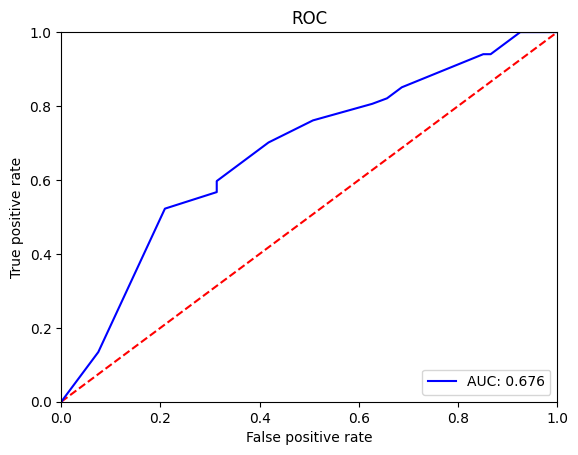

In [15]:
# building the model using n_estimators=200:
model = GradientBoostingClassifier(learning_rate=0.001, max_depth=3, n_estimators=200, random_state=5).fit(x_train, y_train)

# evaluation metrics
print("*** GRADIENT BOOSTING TREES EVALUATION: ***")
c_report_gbt, auc_gbt = evaluation_metrics(model, x_train, x_test, y_train, y_test)

From the train set report we can see that the model does not overfit to the training data anymore which is really good and it means that our tricks worked. Also the prediction performances increased. But even though we reached our goal to make the model not to overfit to the training data we want to see if we can still improve the performance of the model by changing the maximum depth of the trees. To do that we will do exactly the same steps to the variable max_depth than we did to the n_estimators and learning_rate.

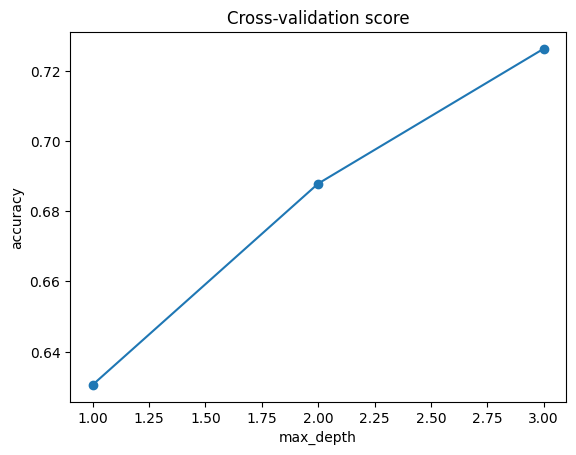

In [31]:
# cross-validation for the max_depth variable:
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.001, random_state=5)
param_grid = {"max_depth" : [1, 2, 3]}
cv_scores(model, param_grid, "accuracy", x_train, y_train)

Because we can see that the accuracy of the model when using the training set would decrease if we would change the max_depth variable value from three we keep it as three.

*** GRADIENT BOOSTING TREES EVALUATION: ***
TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.79      0.71      0.75       157
 surv. status < 5 years       0.74      0.82      0.77       157

               accuracy                           0.76       314
              macro avg       0.76      0.76      0.76       314
           weighted avg       0.76      0.76      0.76       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.63      0.69      0.66        67
 surv. status < 5 years       0.66      0.60      0.62        67

               accuracy                           0.64       134
              macro avg       0.64      0.64      0.64       134
           weighted avg       0.64      0.64      0.64       134



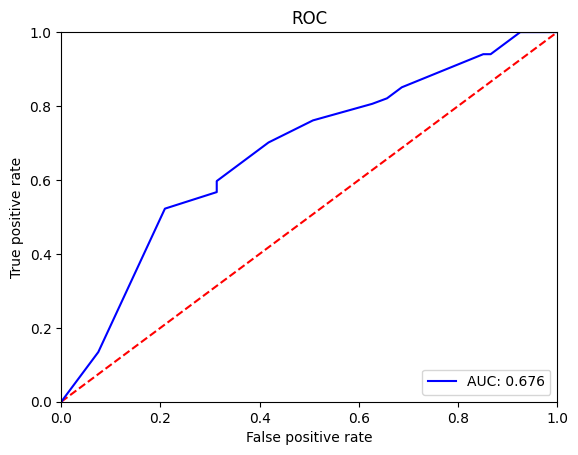

In [20]:
# the final model:
model = GradientBoostingClassifier(learning_rate=0.001, max_depth=3, n_estimators=200, random_state=5).fit(x_train, y_train)

# evaluation metrics
print("*** GRADIENT BOOSTING TREES EVALUATION: ***")
c_report_gbt, auc_gbt = evaluation_metrics(model, x_train, x_test, y_train, y_test)

**THE GRADIENT BOOSTING TREES MODEL EVALUATION:**
- **The accuracy = 0.64:** Shows that the model classified over 60% of the test dataset correctly.
- **The precision:** Tells us that the model classified 63% of the patients correctly which it classified to belong to the survival status five or more years class and 66% of the patients correctly which it classified to belong to the survival status less than five years class.
- **The recall:** Shows us that from all the patients who belong to the survival status five or more years class the model classified correctly 69% and from all the patients who belong to the survival status less than five years class the model classified correctly 60%.
- **The F1-score:** Shows that the model classified better the class survival status five or more years.

**COMPARING THE MODEL TO THE BASELINE MODEL:**

In [35]:
print("**LOGISTIC REGRESSION (BASELINE)**\n", c_report_logreg, "\nAUC:", round(auc_logreg,2))
print("\n---------", "\n**GRADIENT BOOSTING TREES**\n", c_report_gbt, "\nAUC:", round(auc_gbt,2))

**LOGISTIC REGRESSION (BASELINE)**
                          precision    recall  f1-score   support

surv. status >= 5 years       0.61      0.81      0.70        67
 surv. status < 5 years       0.72      0.49      0.58        67

               accuracy                           0.65       134
              macro avg       0.67      0.65      0.64       134
           weighted avg       0.67      0.65      0.64       134
 
AUC: 0.76

--------- 
**GRADIENT BOOSTING TREES**
                          precision    recall  f1-score   support

surv. status >= 5 years       0.63      0.69      0.66        67
 surv. status < 5 years       0.66      0.60      0.62        67

               accuracy                           0.64       134
              macro avg       0.64      0.64      0.64       134
           weighted avg       0.64      0.64      0.64       134
 
AUC: 0.68


From the classification reports we can see that the Gradient Boosting Trees model performed almost as good as our baseline model. The accuracy is only one percent lower than the baseline model's. If we look at the f1-scores of the classes we can see that the Gradient Boosting Trees model classified actually better the class survival status less than five years and it classified only little bit worse the other class than the baseline model. The AUC value is clearly better in the baseline model.

**Even though the Gradient Boosting Trees got better evaluation metrics than K-NN the baseline model performed still best of the first three models.**

**----------**

**Next** we examine the importance of the variables in this model by examining the importance score of the input variables. Basically the importance score means that the higher the score is the more the variable is used in the model's trees to classify the patients.

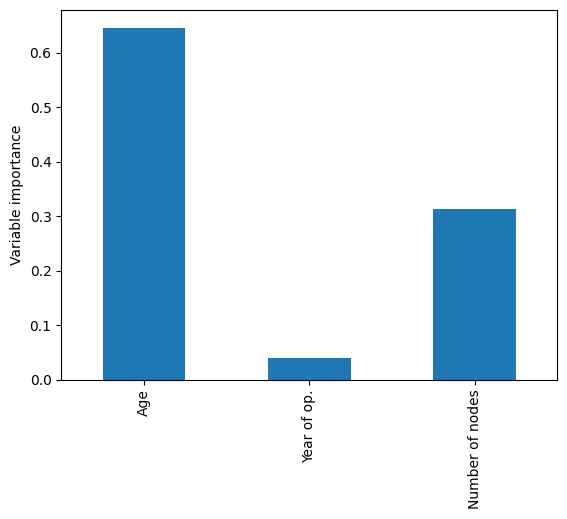

In [36]:
importances = pd.Series(model.feature_importances_, ["Age", "Year of op.", "Number of nodes"])
plt.figure()
importances.plot.bar()
plt.ylabel("Variable importance")
plt.show()

From the figure we can see that the Age variable seems to be the most important variable in this model which is totally different result than we get in our baseline model. In our baseline model (logistic regression) we saw that only Number of nodes variable is statistically significant which means that Age and Year of operation variables are insignificant when classifiyng the patients. When we compare the evaluation metrics between this model and baseline model we can see that the baseline model classified better the test set patients than this model so it seems that maybe Number of node variable is actually more important when classifiyng the patients.

In [22]:
# for the final comparison (section 4):
acc_gbt, pre_gbt, sen_gbt = evaluation_scores(model, x_test, y_test)

# 3.3. Multilayer Perceptron

Next we implement our last supervised learning model which is artificial neural network model Multilayer perceptron. Artificial neural network models tries to copy biological neural networks. The artificial neural networks consist of input layer, hidden layer/layers (can have differet amount of hidden layers) and output layer which consist of nodes. The activation functions are used to calculate if the node will activate or not based on the previous layer's nodes. 

Artificial neural network models has a lot of factors to be determined for example activation functions between different layers, the amount of hidden layers, learning rate etc. Because of that we are not going to search the optimal option for all of the factors. What we are going to do is that we use the default options in most of the factors and we will optimize the amount of hidden layers and nodes in hidden layers and the weight of the regularization term (= alpha). As an activation function between the hidden layers we will use the rectified linear unit function.

In [20]:
import warnings
warnings.filterwarnings('ignore')

# finding the optimal parameters
param_grid = {"alpha" : [1e-04, 1e-03, 1e-02, 1e-01], 
             "hidden_layer_sizes" : [(5,), (10,), (5,5), (10,10), (5,10), (10,5), (15,15)]} # (amount of nodes, amount of layers)
grid = GridSearchCV(MLPClassifier(random_state=3), param_grid, scoring="accuracy", cv=5)
grid.fit(x_train, y_train)
print("The optimal parameters:", grid.best_params_)
print("The accuracy score:", grid.best_score_)

The optimal parameters: {'alpha': 0.0001, 'hidden_layer_sizes': (10, 10)}
The accuracy score: 0.6560675883256527


TRAIN SET REPORT:
                         precision    recall  f1-score   support

surv. status >= 5 years       0.69      0.76      0.73       157
 surv. status < 5 years       0.74      0.66      0.69       157

               accuracy                           0.71       314
              macro avg       0.71      0.71      0.71       314
           weighted avg       0.71      0.71      0.71       314

TEST SET REPORT (PREDICTION):
                         precision    recall  f1-score   support

surv. status >= 5 years       0.56      0.72      0.63        67
 surv. status < 5 years       0.60      0.43      0.50        67

               accuracy                           0.57       134
              macro avg       0.58      0.57      0.57       134
           weighted avg       0.58      0.57      0.57       134



C:\Users\Vili Niemelä\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


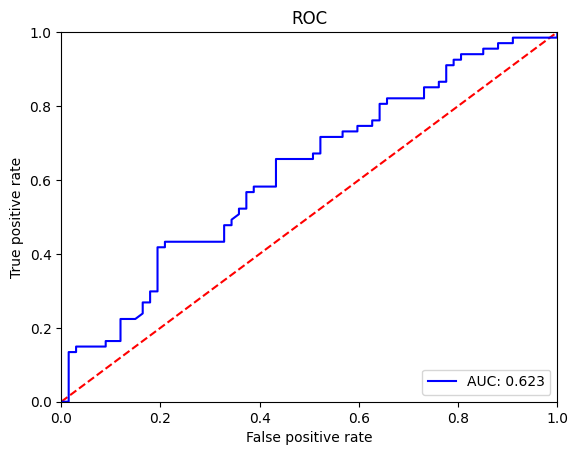

In [23]:
# implementing the model using optimal parameters
model = MLPClassifier(random_state=3, alpha=0.0001, hidden_layer_sizes=(10,10)).fit(x_train, y_train)
c_report_mp, auc_mp = evaluation_metrics(model, x_train, x_test, y_train, y_test)

As we can see the Multilayer Perceptron didn't perform well classifying the test set and the reason is not this time overfitting to the training data because for example the accuracy of the training set report is only 71%.

**COMPARING THE MODEL TO THE BASELINE MODEL:**

In [23]:
print("**LOGISTIC REGRESSION (BASELINE)**\n", c_report_logreg, "\nAUC:", round(auc_logreg,2))
print("\n---------", "\n**MULTILAYER PERCEPTRON**\n", c_report_mp, "\nAUC:", round(auc_mp,2))

**LOGISTIC REGRESSION (BASELINE)**
                          precision    recall  f1-score   support

surv. status >= 5 years       0.61      0.81      0.70        67
 surv. status < 5 years       0.72      0.49      0.58        67

               accuracy                           0.65       134
              macro avg       0.67      0.65      0.64       134
           weighted avg       0.67      0.65      0.64       134
 
AUC: 0.76

--------- 
**MULTILAYER PERCEPTRON**
                          precision    recall  f1-score   support

surv. status >= 5 years       0.56      0.72      0.63        67
 surv. status < 5 years       0.60      0.43      0.50        67

               accuracy                           0.57       134
              macro avg       0.58      0.57      0.57       134
           weighted avg       0.58      0.57      0.57       134
 
AUC: 0.62


When comparing the Multilayer Perceptron to the baseline model we can see that every evaluation metrics has lower value in the MP model than in the baseline model. That is why we can definetely say that **Multilayer Perceptron performed worse than our baseline model.**

In [24]:
# for the final comparison (section 4):
acc_mp, pre_mp, sen_mp = evaluation_scores(model, x_test, y_test)

# 4. Comparison of the models

After implementing and evaluating all the models we will compare them and make the final conclusion that which model is the best for our purpose based on the evaluating metrics we have computed to the models.

To make the comparison easier we won't use all the evaluation metrics. We will use AUC, accuracy, sensitivity and precision. 

In [27]:
table = df()
table["Models"] = ["Log. reg.", "K-NN", "GBT", "MP"]
table["Accuracy"] = [acc_lr, acc_knn, acc_gbt, acc_mp]
table["Precision"] = [pre_lr, pre_knn, pre_gbt, pre_mp]
table["Sensitivity"] = [sen_lr, sen_knn, sen_gbt, sen_mp]
table["AUC"] = [auc_logreg, auc_knn, auc_gbt, auc_mp]
table.set_index("Models", inplace=True)
table

,Accuracy,Precision,Sensitivity,AUC
Models,,,,
Log. reg.,0.649254,0.717391,0.492537,0.756293
K-NN,0.619403,0.700000,0.417910,0.639675
GBT,0.641791,0.655738,0.597015,0.675763
MP,0.574627,0.604167,0.432836,0.622633


From the table we can see that our baseline model has the best score almost in every evaluation metrics. In only sensitivity the Gradient Boosting Trees models is better than our baseline model. Because of that it is easy to just pick the logistic regression model as the best model.

What is interesting is that the artificial neural network model Multilayer Perceptron performed pretty badly when comparing to other models. For example it has the lowest score in every metrics but sensitivity. Even though it is probably the most complicated model, the performance is the worst. 

If we don't take into account our baseline model the best model of the three supervised models is the Gradient Boosting Trees model because it has better accuracy, sesitivity and AUC than the other two. Actually the performance of the model is not so far from our baseline model because the accuracy score is only 0.008 points lower and the sensitivity score is even better for ten points. AUC and precision score are both over five points lower than the baseline model's.

If we look at the evaluation metrics in every model we can see that the values are not so high which tells us that neither model was able to classify the testing dataset well. For example even our best model the logistic regression was able to only classify 64% of the testing data correctly which is quite low if we should use it in a real life. Probably by digging more deeper in training the models we would be able to improve the performance of the models but to do that we have to learn more from the models. 